In [9]:
!pip install tensorflow keras opencv-python matplotlib numpy scikit-learn imbalanced-learn tabulate seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import RandomOverSampler
from tabulate import tabulate

In [11]:
# ## 3. Dataset Preparation

# %%
# Define paths
base_dir = "C:/Users/supereme/Desktop/CNN"
class_names = ['healthy', 'new_disease', 'powdery_mildew']

# Create lists to store images and labels
images = []
labels = []
# Load images
for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(base_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))  # VGG16 input size
            images.append(img)
            labels.append(class_idx)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images total")
print(f"Class distribution: {np.bincount(labels)}")

Loaded 15 images total
Class distribution: [5 5 5]


In [12]:
# ## 4. Data Augmentation

# %%
# Create augmented dataset
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)
# Generate augmented images
augmented_images = []
augmented_labels = []

for img, label in zip(images, labels):
    img = img.reshape((1,) + img.shape)  # Add batch dimension
    aug_iter = datagen.flow(img, batch_size=1)
    for i in range(20):  # Generate 20 augmented versions per image
        augmented_img = next(aug_iter)[0].astype('uint8')
        augmented_images.append(augmented_img)
        augmented_labels.append(label)

# Combine original and augmented data
all_images = np.concatenate([images, np.array(augmented_images)])
all_labels = np.concatenate([labels, np.array(augmented_labels)])
print(f"Total images after augmentation: {len(all_images)}")
print(f"New class distribution: {np.bincount(all_labels)}")

Total images after augmentation: 315
New class distribution: [105 105 105]


In [13]:
# ## 5. Data Splitting and Balancing

# %%
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Further split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Balance the dataset using oversampling
ros = RandomOverSampler(random_state=42)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Flatten images for oversampling
X_train_balanced, y_train_balanced = ros.fit_resample(X_train_reshaped, y_train)
X_train_balanced = X_train_balanced.reshape(-1, 224, 224, 3)  # Reshape back to images
print("\nDataset sizes:")
print(f"Training: {X_train_balanced.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples")
print(f"Testing: {X_test.shape[0]} samples")


Dataset sizes:
Training: 201 samples
Validation: 51 samples
Testing: 63 samples


In [14]:
# ## 6. Model Building - VGG16

# %%
# Load pre-trained VGG16 without top layer
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = Flatten()(x)  # VGG16 typically uses Flatten instead of GlobalAveragePooling
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.4682 - loss: 34.2977 - val_accuracy: 0.6863 - val_loss: 32.9045 - learning_rate: 0.0010
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.7904 - loss: 24.9144 - val_accuracy: 0.8039 - val_loss: 14.6337 - learning_rate: 0.0010
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.9297 - loss: 3.0855 - val_accuracy: 0.8431 - val_loss: 5.7070 - learning_rate: 0.0010
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.9769 - loss: 1.4571 - val_accuracy: 0.8824 - val_loss: 7.4364 - learning_rate: 0.0010
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 67s 5s/step - accuracy: 0.9753 - loss: 0.5433 - val_accuracy: 0.8627 - val_loss: 9.7825 - learning_rate: 0.0010
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.9871 - loss: 0.5860 - val_accuracy: 0.9020 - val_loss: 9.0433 - learning_rate: 0.0010
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.9818 - loss: 0.6216 - val

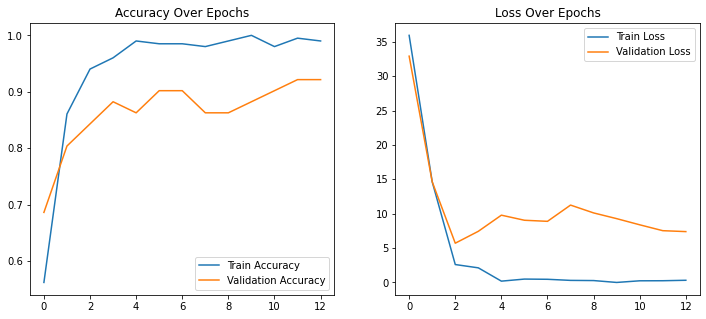

In [15]:
# ## 7. Model Training

# %%
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.00001
)
# Train the model
history = model.fit(
    X_train_balanced,
    y_train_balanced,
    batch_size=16,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

Test Accuracy: 0.9365
Test Loss: 1.2753
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step

Classification Report:
                precision    recall  f1-score   support

       healthy       0.84      1.00      0.91        21
   new_disease       1.00      1.00      1.00        21
powdery_mildew       1.00      0.81      0.89        21

      accuracy                           0.94        63
     macro avg       0.95      0.94      0.94        63
  weighted avg       0.95      0.94      0.94        63



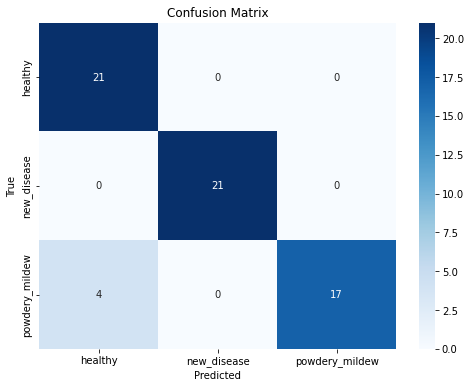

In [16]:
# ## 8. Model Evaluation

# %%
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

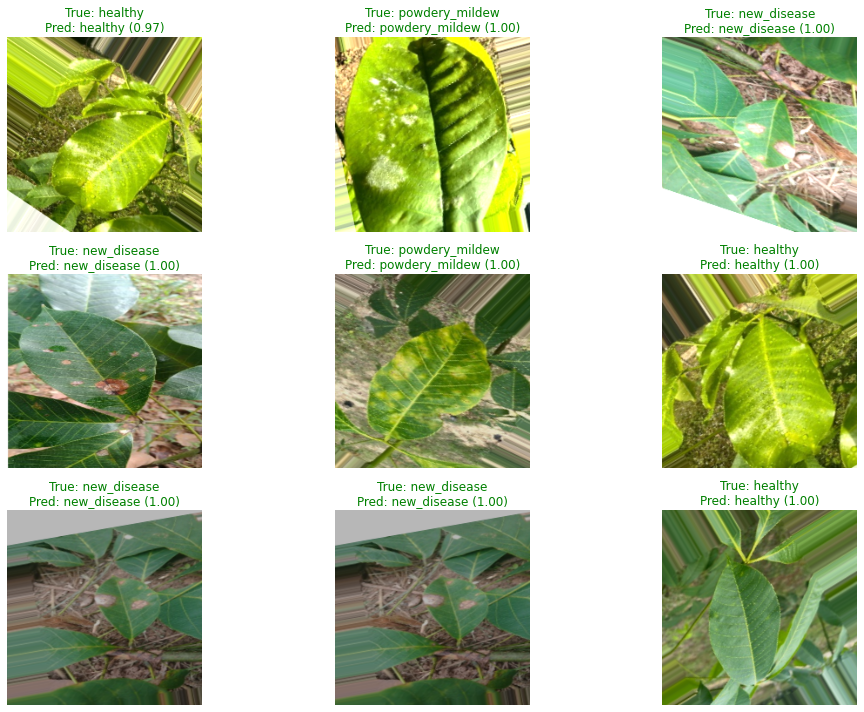

In [20]:
# ## 12. Sample Predictions Visualization

# %%
# Display sample predictions
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    idx = np.random.randint(0, len(X_test))
    plt.imshow(X_test[idx].astype('uint8'))
    true_class = class_names[y_test[idx]]
    pred_class = class_names[y_pred_classes[idx]]
    confidence = np.max(y_pred[idx])
    title_color = 'green' if true_class == pred_class else 'red'
    plt.title(f"True: {true_class}\nPred: {pred_class} ({confidence:.2f})", color=title_color)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
# ## 13. Save Model and Results

# %%
# Save the model
model.save('rubber_leaf_vgg16.h5')
print("Model saved as 'rubber_leaf_vgg16.h5'")

# Save training history
import pickle
with open('vgg16_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("Training history saved")

# Save performance metrics
import json
with open('vgg16_performance_metrics.json', 'w') as f:
    json.dump(report, f)
print("Performance metrics saved")

# Save the performance table as CSV
import pandas as pd
df = pd.DataFrame(performance_table[1:], columns=performance_table[0])
df.to_csv('vgg16_performance_table.csv', index=False)
print("Performance table saved as CSV")

Model saved as 'rubber_leaf_vgg16.h5'
Training history saved
Performance metrics saved
Performance table saved as CSV


In [23]:
import time
import os
import tensorflow as tf
from tabulate import tabulate

# Load or define your model
# model = tf.keras.models.load_model('rubber_leaf_vgg16.h5')  # Uncomment if you're loading

# Measure model size in MB
model_path = 'rubber_leaf_vgg16.h5'
model_size = os.path.getsize(model_path) / (1024 * 1024)

# Count parameters (in millions)
num_params = model.count_params() / 1e6

# Record training time
start_train_time = time.time()
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
end_train_time = time.time()
train_runtime = end_train_time - start_train_time
train_runtime_per_epoch = train_runtime / len(history.epoch)

# Optional fine-tuning step (if applicable)
# start_fine_time = time.time()
# history_fine = model.fit(...)
# end_fine_time = time.time()
# fine_runtime = end_fine_time - start_fine_time
# total_train_runtime = train_runtime + fine_runtime

# Measure test time
start_test_time = time.time()
_ = model.evaluate(X_test, y_test, verbose=0)
test_runtime = time.time() - start_test_time

# Prepare summary
summary_table = [
    ["Size (MB)", f"{model_size:.2f}"],
    ["Parameters (M)", f"{num_params:.2f}"],
    ["Training Runtime (s)", f"{train_runtime:.2f}"],
    ["Runtime per Epoch (s)", f"{train_runtime_per_epoch:.2f}"],
    ["Test Runtime (s)", f"{test_runtime:.2f}"]
]

print("\nModel Summary:")
print(tabulate(summary_table, headers=["Metric", "Value"], tablefmt="grid"))


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 198s 28s/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 179s 26s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0094
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 183s 26s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 176s 25s/step - accuracy: 1.0000 - loss: 8.7246e-04 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 180s 26s/step - accuracy: 1.0000 - loss: 8.3747e-04 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 182s 26s/step - accuracy: 1.0000 - loss: 4.0124e-04 - val_accuracy: 1.0000 - val_loss: 0.0088
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 186s 27s/step - accuracy: 1.0000 - loss: 5.5878e-04 - val_accuracy: 1.0000 - val_loss: 0.0091
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 251s 37s/step - accuracy: 1.0000 - loss: 2.4468e-04 - val_accuracy